### Exercitiul 1

Mai întâi, organizăm datele astfel încât în n_values să includem numărul total de utilizatori pentru fiecare dintre cele 7 zile, iar în k_values să notăm numărul utilizatorilor care au finalizat achiziția în fiecare dintre aceste zile.

În continuare, definim modelul probabilistic, incluzând rata medie globală, care este o valoare deterministă calculată pe baza datelor. La final, afișăm distribuția a posteriori pentru a analiza rezultatele.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


<Axes: title={'center': 'p_mean'}>

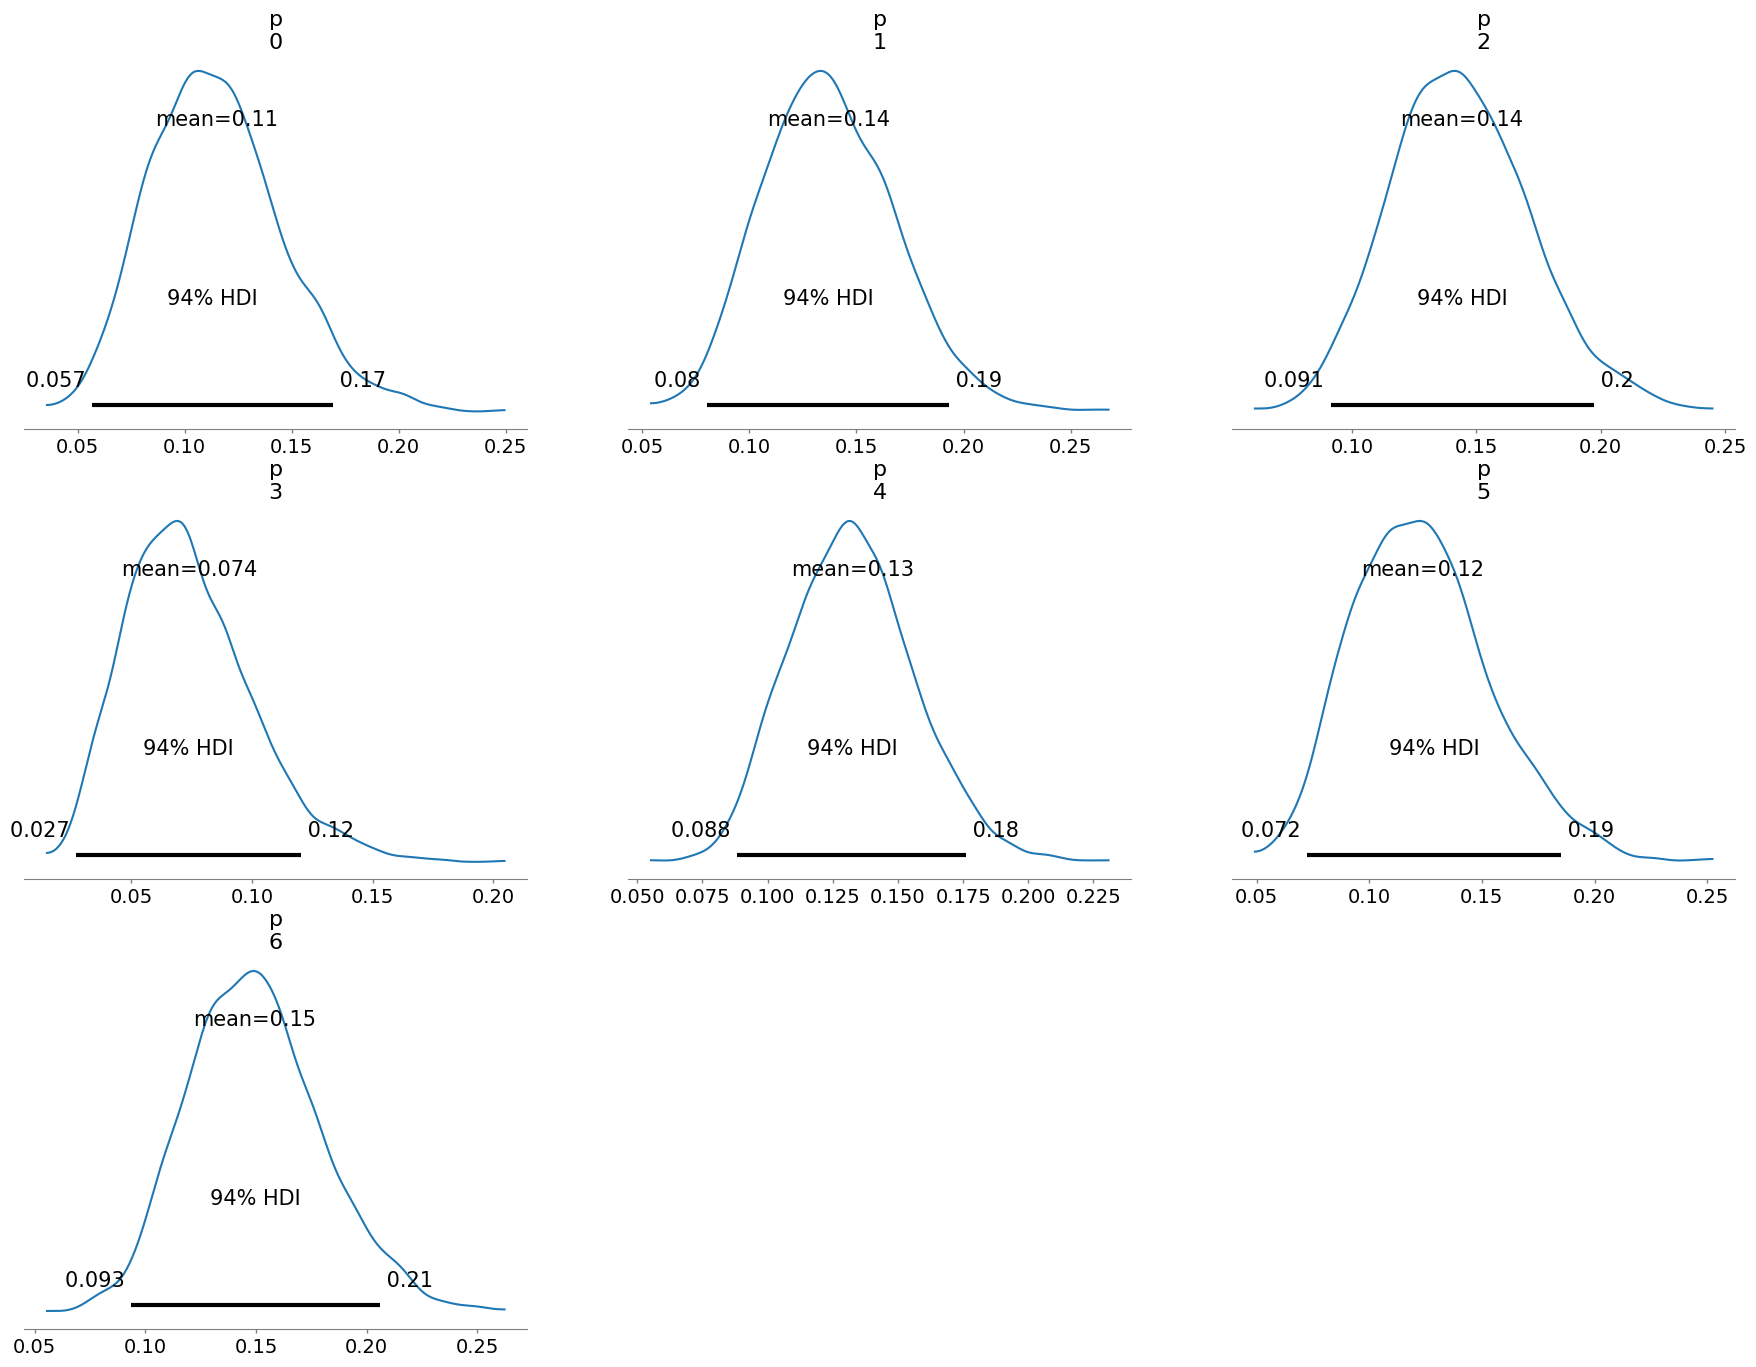

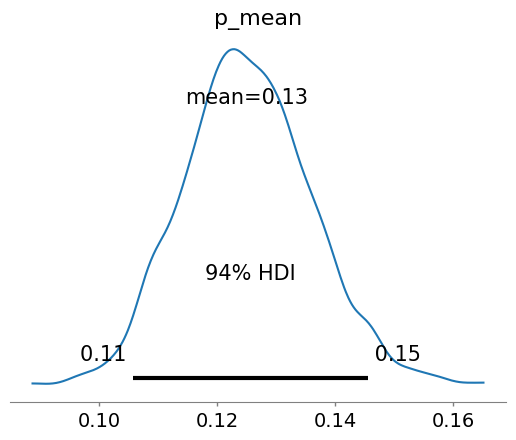

In [13]:
import pymc as pm
import arviz as az

n_values = [100, 120, 150, 90, 200, 110, 130]
k_values = [10, 15, 20, 5, 25, 12, 18]
with pm.Model() as UsersModel:
    # a priori
    p = pm.Beta('p', alpha = 2, beta = 2, shape = 7)

    # likelihood
    k = pm.Binomial('k', n = n_values, p = p, observed = k_values)

    p_mean = pm.Deterministic('p_mean', pm.math.mean(p))

    # sampling
    trace = pm.sample(1000, return_inferencedata = True)

az.plot_posterior(trace, var_names=['p'])
az.plot_posterior(trace, var_names=['p_mean'])

Pentru distribuția a posteriori $p_0$, care reprezintă rata zilnică de finalizare a utilizatorilor în prima zi a săptămânii, estimăm o rată medie de 
0.12, ceea ce înseamnă că, în medie, 12% dintre utilizatori finalizează achizițiile. Intervalul de credibilitate de 94% (HDI – Highest Density Interval) pentru această rată este [0.058, 0.17], ceea ce indică faptul că, cu o probabilitate de 94%, rata reală se află în acest interval.

Pentru întreaga săptămână, rata medie globală de finalizare a utilizatorilor este estimată tot la 0.12. Intervalul de credibilitate de 94% pentru această medie globală este [0.11, 0.15], ceea ce reflectă faptul că, cu o probabilitate de 94%, rata reală se încadrează în acest interval.

### Exercitiul 2

Mai întâi, importăm datele din fișierul CSV și le salvăm într-un DataFrame utilizând biblioteca Pandas. În continuare, reprezentăm grafic numărul de mașini pentru fiecare minut, în intervalul orar 4:00 - 24:00.

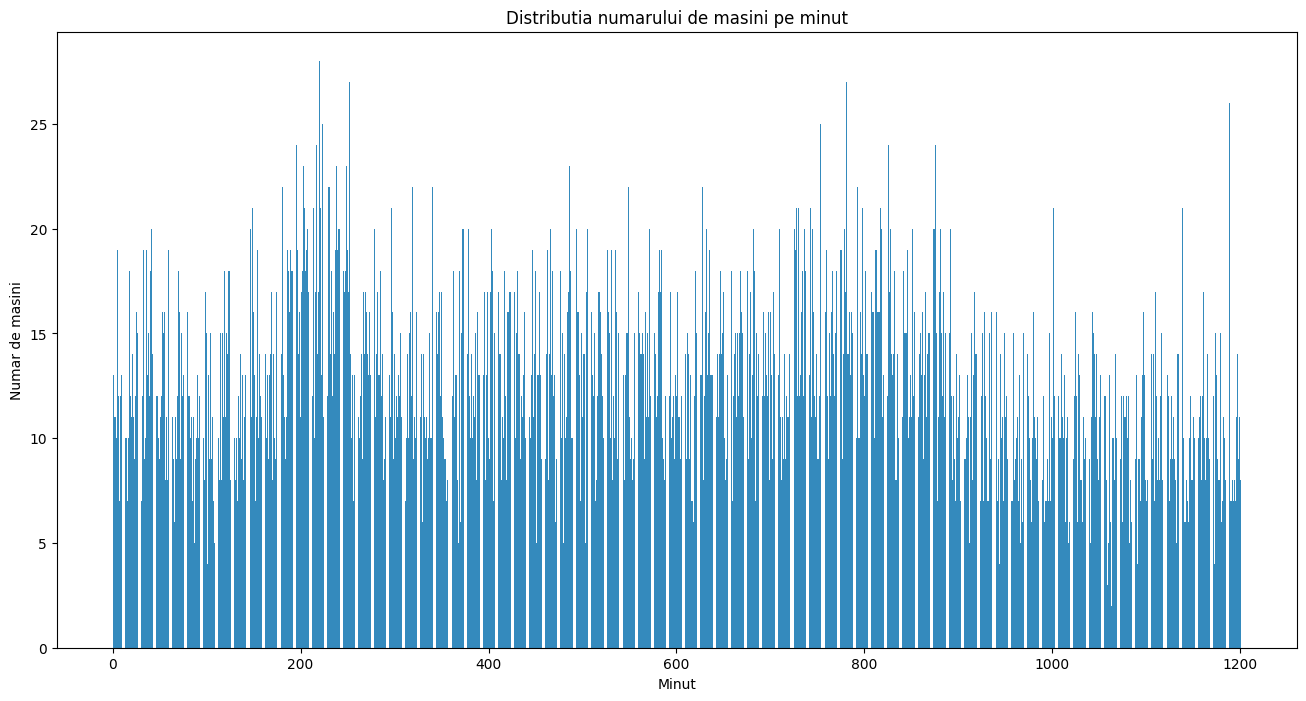

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


data = pd.read_csv('trafic.csv')
minutes = data['minut'] 
num_of_cars = data['nr. masini']  

plt.figure(figsize=(16, 8))  
plt.bar(minutes, num_of_cars, color = '#348ABD')
plt.xlabel('Minut')
plt.ylabel('Numar de masini')
plt.title('Distributia numarului de masini pe minut')
plt.show()

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

# Citirea și pregătirea datelor
df = pd.read_csv('trafic.csv')

# Convertim minutele în fracțiuni de oră (pornind de la ora 4:00)
df['hour'] = 4 + df['minut'] / 60

# Definirea modelului
with pm.Model() as model:
    # Prior pentru punctele de schimbare în jurul orelor cunoscute
    cp1 = pm.Normal('cp1', mu=7, sigma=0.5)   # În jurul orei 7:00
    cp2 = pm.Normal('cp2', mu=8, sigma=0.5)   # În jurul orei 8:00
    cp3 = pm.Normal('cp3', mu=16, sigma=0.5)  # În jurul orei 16:00
    cp4 = pm.Normal('cp4', mu=19, sigma=0.5)  # În jurul orei 19:00

    # Priori pentru parametrii lambda în fiecare interval
    lambda1 = pm.HalfNormal('lambda1', sigma=20)  # Intervalul 4:00 - cp1
    lambda2 = pm.HalfNormal('lambda2', sigma=20)  # Intervalul cp1 - cp2
    lambda3 = pm.HalfNormal('lambda3', sigma=20)  # Intervalul cp2 - cp3
    lambda4 = pm.HalfNormal('lambda4', sigma=20)  # Intervalul cp3 - cp4
    lambda5 = pm.HalfNormal('lambda5', sigma=20)  # Intervalul cp4 - 24:00

    # Calcularea lui lambda_t pentru fiecare moment în timp
    hour = df['hour'].values
    lambda_t = pm.math.switch(hour < cp1, lambda1,
                 pm.math.switch(hour < cp2, lambda2,
                     pm.math.switch(hour < cp3, lambda3,
                         pm.math.switch(hour < cp4, lambda4, lambda5))))

    # Verosimilitatea (Poisson)
    y = pm.Poisson('y', mu=lambda_t, observed=df['nr. masini'])

    # Eșantionarea
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Analiza rezultatelor
# Extragem valorile medii pentru punctele de schimbare și lambda
summary = az.summary(trace)

# Afișarea rezultatelor direct
print("\nCele mai probabile momente ale punctelor de schimbare (ore):")
print(f"Punct de schimbare 1: {summary.loc['cp1', 'mean']:.2f} ore")
print(f"Punct de schimbare 2: {summary.loc['cp2', 'mean']:.2f} ore")
print(f"Punct de schimbare 3: {summary.loc['cp3', 'mean']:.2f} ore")
print(f"Punct de schimbare 4: {summary.loc['cp4', 'mean']:.2f} ore")

print("\nCele mai probabile valori ale lui lambda pentru fiecare interval:")
print(f"Lambda 1: {summary.loc['lambda1', 'mean']:.2f} mașini/minut")
print(f"Lambda 2: {summary.loc['lambda2', 'mean']:.2f} mașini/minut")
print(f"Lambda 3: {summary.loc['lambda3', 'mean']:.2f} mașini/minut")
print(f"Lambda 4: {summary.loc['lambda4', 'mean']:.2f} mașini/minut")
print(f"Lambda 5: {summary.loc['lambda5', 'mean']:.2f} mașini/minut")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cp1, cp2, cp3, cp4, lambda1, lambda2, lambda3, lambda4, lambda5]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1066 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Cele mai probabile momente ale punctelor de schimbare (ore):
Punct de schimbare 1: 6.64 ore
Punct de schimbare 2: 8.40 ore
Punct de schimbare 3: 15.59 ore
Punct de schimbare 4: 19.03 ore

Cele mai probabile valori ale lui lambda pentru fiecare interval:
Lambda 1: 12.14 mașini/minut
Lambda 2: 16.28 mașini/minut
Lambda 3: 12.97 mașini/minut
Lambda 4: 14.48 mașini/minut
Lambda 5: 10.13 mașini/minut


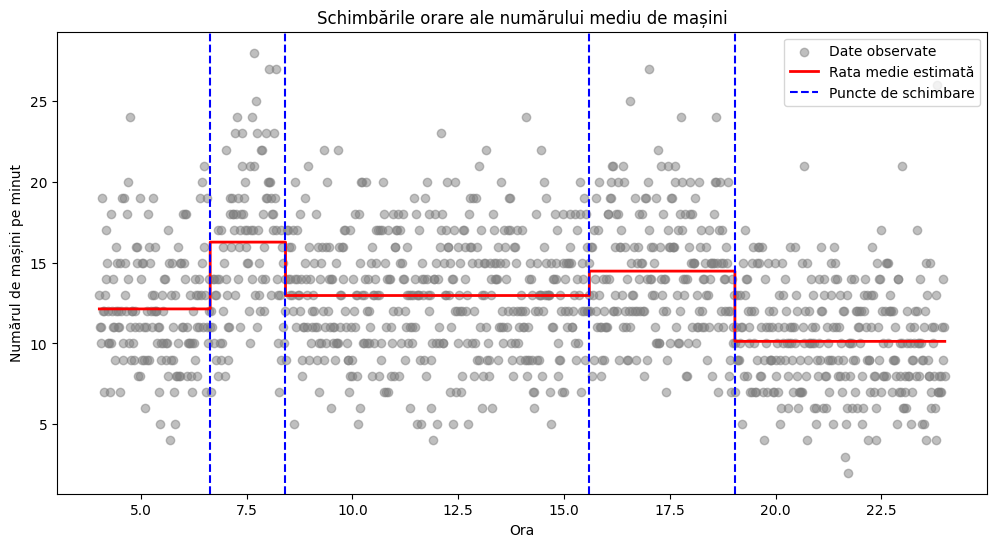

In [5]:
import matplotlib.pyplot as plt

# Extragem valorile medii ale parametrilor
cp1_mean = summary.loc['cp1', 'mean']
cp2_mean = summary.loc['cp2', 'mean']
cp3_mean = summary.loc['cp3', 'mean']
cp4_mean = summary.loc['cp4', 'mean']

lambda1_mean = summary.loc['lambda1', 'mean']
lambda2_mean = summary.loc['lambda2', 'mean']
lambda3_mean = summary.loc['lambda3', 'mean']
lambda4_mean = summary.loc['lambda4', 'mean']
lambda5_mean = summary.loc['lambda5', 'mean']

# Creăm o funcție care mapează fiecare interval la lambda corespunzător
def get_lambda_estimate(hour):
    if hour < cp1_mean:
        return lambda1_mean
    elif hour < cp2_mean:
        return lambda2_mean
    elif hour < cp3_mean:
        return lambda3_mean
    elif hour < cp4_mean:
        return lambda4_mean
    else:
        return lambda5_mean

# Aplicăm funcția pentru un interval de timp
time_range = np.linspace(df['hour'].min(), df['hour'].max(), 1000)
lambda_estimates = [get_lambda_estimate(h) for h in time_range]

# Reprezentarea grafică
plt.figure(figsize=(12, 6))

# Afișăm datele observate
plt.scatter(df['hour'], df['nr. masini'], color='gray', alpha=0.5, label='Date observate')

# Afișăm rata medie estimată a traficului
plt.step(time_range, lambda_estimates, where='post', color='red', linewidth=2, label='Rata medie estimată')

# Afișăm liniile verticale pentru punctele de schimbare
plt.axvline(x=cp1_mean, color='blue', linestyle='--', label='Puncte de schimbare')
plt.axvline(x=cp2_mean, color='blue', linestyle='--')
plt.axvline(x=cp3_mean, color='blue', linestyle='--')
plt.axvline(x=cp4_mean, color='blue', linestyle='--')

# Etichete și titlu
plt.xlabel('Ora')
plt.ylabel('Numărul de mașini pe minut')
plt.title('Schimbările orare ale numărului mediu de mașini')
plt.legend()

plt.show()